In [1]:
import random
import pickle
import logging
from os.path import join
from collections import Counter
import pandas as pd
from indra.tools import assemble_corpus as ac
from indra.statements import Complex, Phosphorylation
from bioexp.util import pklload
from bioexp.curation.classifiers import BinaryRandomForest, LogLogisticRegression
from indra.ontology.bio import bio_ontology as bo
from indra.preassembler import Preassembler
from indra.belief.sklearn import SklearnScorer
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from indra.util import plot_formatting as pf
from indra.assemblers.html import HtmlAssembler
from indra.belief.sklearn.wrapper import CountsModel
from indra.sources.biogrid import BiogridProcessor
from indra.tools import assemble_corpus as ac
from indra.statements import Complex
from bioexp.curation.classifiers import LogLogisticRegression, BinaryRandomForest

%matplotlib notebook

opath = '../output/'
prefix = 'fig5_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

logger = logging.getLogger('biogrid_benchmark')

# Load curation data

Load the curation dataset and the preassembled statements:

In [2]:
def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agBns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

# Get dataset of curated statements along with correctness values
def stmts_for_df(df, stmts_by_hash):
    stmt_list = []
    for row in kge_df.itertuples():
        stmt_hash = row.stmt_hash
        stmt_list.append(stmts_by_hash[stmt_hash])
    return stmt_list

# Load pickle of assembled statements.
#indra_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')
indra_stmts = ac.load_statements('../output/bioexp_reading_only_asmb_preassembled.pkl')
stmts_by_hash = {s.get_hash(): s for s in indra_stmts}
# Load the curated data
curation_data_file = 'curation_dataset_with_bg_psp.pkl'
kge_df = load_curation_data(curation_data_file)
# Get statements from curation dataframe
kge_stmts = stmts_for_df(kge_df, stmts_by_hash)

INFO: [2021-04-28 09:50:38] indra.tools.assemble_corpus - Loading ../output/bioexp_reading_only_asmb_preassembled.pkl...
INFO: [2021-04-28 09:51:27] indra.tools.assemble_corpus - Loaded 734208 statements


In [7]:
y_arr = kge_df['correct'].values

In [8]:
all_sources = list(set([ev.source_api for stmt in kge_stmts for ev in stmt.evidence]))
all_sources

['medscan', 'isi', 'reach', 'sparser', 'rlimsp', 'trips']

# Fit model to all curation data

In [9]:
# Create a CountsModel for this type of classifier
clf = LogLogisticRegression()
model = CountsModel(clf, all_sources, use_stmt_type=True, use_num_pmids=True)
# Use instance of CountsModel to get feature data as a matrix
# with appropriate featurization
model.fit(kge_stmts, y_arr)

# Biogrid Benchmark

Load the Biogrid statements:

In [10]:
reload = False
bg_stmts_file = join(opath, 'bg_stmts_asmb.pkl')

if reload:
    bp = BiogridProcessor()
    bg_stmts_raw = bp.statements
    # De-duplicate the Biogrid statements:
    pa = Preassembler(bo, stmts=bg_stmts_raw)
    bg_stmts_asmb = pa.combine_duplicates()
    # Save statements to file
    with open(bg_stmts_file, 'wb') as f:
        pickle.dump(bg_stmts_asmb, f)
else:
    with open(bg_stmts_file, 'rb') as f:
        bg_stmts_asmb = pickle.load(f)

Filter both the INDRA-assembled and Biogrid statements to Complexes of human genes:

In [7]:
def filter_stmts(stmts, stmt_type):
    stmts = ac.filter_by_type(stmts, stmt_type)
    stmts = ac.filter_genes_only(stmts, specific_only=True)
    stmts = ac.filter_human_only(stmts)
    stmts = [s for s in stmts if None not in [ag for ag in s.agent_list()]]
    return stmts

# Filter to Complex of human genes
bg_stmts_filt = filter_stmts(bg_stmts_asmb, Complex)
indra_stmts_filt_cplx = filter_stmts(indra_stmts, Complex)

INFO: [2021-04-06 11:51:08] indra.tools.assemble_corpus - Filtering 879442 statements for type Complex...
INFO: [2021-04-06 11:51:08] indra.tools.assemble_corpus - 879442 statements after filter...
INFO: [2021-04-06 11:51:08] indra.tools.assemble_corpus - Filtering 879442 statements for ones containing genes only...
INFO: [2021-04-06 11:51:12] indra.tools.assemble_corpus - 836615 statements after filter...
INFO: [2021-04-06 11:51:13] indra.tools.assemble_corpus - Filtering 836615 statements for human genes only...
INFO: [2021-04-06 11:51:33] indra.tools.assemble_corpus - 482827 statements after filter...
INFO: [2021-04-06 11:51:35] indra.tools.assemble_corpus - Filtering 734208 statements for type Complex...
INFO: [2021-04-06 11:51:35] indra.tools.assemble_corpus - 166703 statements after filter...
INFO: [2021-04-06 11:51:35] indra.tools.assemble_corpus - Filtering 166703 statements for ones containing genes only...
INFO: [2021-04-06 11:51:36] indra.tools.assemble_corpus - 127300 state

Use the trained belief model to assign belief values to statements:

In [8]:
beliefs = model.predict_proba(indra_stmts_filt_cplx)[:, 1]
for ix, stmt in enumerate(indra_stmts_filt_cplx):
    stmt.belief = beliefs[ix]

In [9]:
# Compare 
bg_hashes = set([s.get_hash(refresh=True) for s in bg_stmts_filt])
indra_hashes_cplx = set([s.get_hash(refresh=True) for s in indra_stmts_filt_cplx])

Stratify statements by belief bins:

In [10]:
def stmts_in_bg_by_belief(stmts, bg_hashes, bin_info, stmts_by_hash):
    in_bg = np.zeros(len(bin_info))
    not_in_bg = np.zeros(len(bin_info))
    in_bg_stmts = {}
    not_in_bg_stmts = {}
    for i, (lbound, ubound, label) in enumerate(bin_info):
        stmts_by_belief = [s for s in stmts
                           if s.belief > lbound and s.belief <= ubound]
        bin_hashes = set([s.get_hash(refresh=True) for s in stmts_by_belief])
        in_bg_hashes = bin_hashes.intersection(bg_hashes)
        not_in_bg_hashes = bin_hashes.difference(in_bg_hashes)

        in_bg[i] = len(in_bg_hashes)
        not_in_bg[i] = len(not_in_bg_hashes)
        in_bg_stmts[label] = [stmts_by_hash[h] for h in in_bg_hashes]
        not_in_bg_stmts[label] = [stmts_by_hash[h] for h in not_in_bg_hashes]
    return {'in_bg_cts': in_bg,
            'not_in_bg_cts': not_in_bg,
            'in_bg_stmts': in_bg_stmts,
            'not_in_bg_stmts': not_in_bg_stmts}

# Group indra stmts by belief bin and get counts and statements for the
# ones in Biogrid vs. not in Biogrid

def get_bin_info(bin_bounds):
     return [(bin_bounds[i], bin_bounds[i+1],
             f'{bin_bounds[i]}_{bin_bounds[i+1]}')
             for i in range(len(bin_bounds) - 1)]

bin_bounds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]
bin_info = get_bin_info(bin_bounds)

in_bg_info = stmts_in_bg_by_belief(indra_stmts_filt_cplx, bg_hashes,
                                   bin_info, stmts_by_hash)


Plot belief distribution along with BG/not in BG status:

In [11]:
# Plot statement counts
def plot_in_db(in_db_dict, bin_info, db_name):
    index = np.array(range(len(bin_info)))
    fig = plt.figure(figsize=(2.5, 2), dpi=150)
    plt.bar(index, in_db_dict['not_in_bg_cts'],
            bottom=in_db_dict['in_bg_cts'], label=f'Not In {db_name}')
    plt.bar(index, in_db_dict['in_bg_cts'], label=f'In {db_name}')
    ax = plt.gca()
    ax.set_xticks(index)
    tls = [lb for lb, _, _ in bin_info]
    print(tls)
    ax.set_xticklabels(tls, rotation='vertical')
    pf.format_axis(ax)
    plt.ylabel('Number of Statements')
    plt.xlabel('Belief bin lower bound')
    pf.format_axis(ax)

    plt.legend(loc='upper right', fontsize=pf.fontsize, frameon=False)
    plt.subplots_adjust(bottom=0.2, left=0.2)
    return fig
    
def plot_frac_in_db(in_db_dict, bin_info, db_name):
    fracs_in_db = []
    lbs = []
    for i, (lb, _, _) in enumerate(bin_info):
        numer = in_db_dict['in_bg_cts'][i]
        denom = in_db_dict['not_in_bg_cts'][i] + numer
        # If there are no statements in this bin, skip it
        if denom == 0:
            continue
        lbs.append(lb)
        fracs_in_db.append(numer / denom)

    # Plot statement percentages
    fig = plt.figure(figsize=(2, 2), dpi=150)
    print(list(zip(lbs, fracs_in_db)))
    plt.plot(lbs, fracs_in_db, marker='.')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax = plt.gca()
    ax.set_xticks(lbs)
    ax.set_xticklabels(lbs, rotation='vertical')
    pf.format_axis(ax)
    plt.ylabel(f'Frac. in {db_name}')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xlabel('Belief bin lower bound')
    plt.subplots_adjust(bottom=0.2, left=0.2)
    return fig

<IPython.core.display.Javascript object>


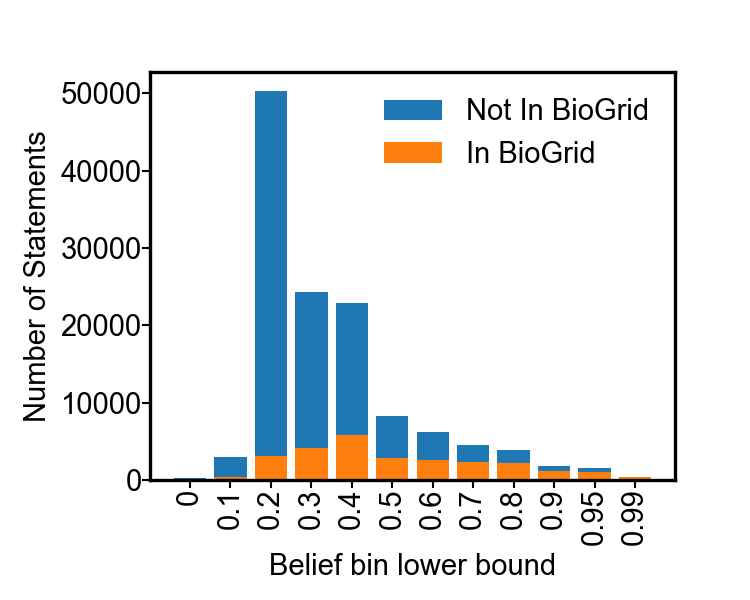

[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]


In [16]:
fig = plot_in_db(in_bg_info, bin_info, 'BioGrid')
plt.savefig(fig_path('in_bg_cts', 'pdf'))

Plot the proportion of statements in each bin in Biogrid:

<IPython.core.display.Javascript object>


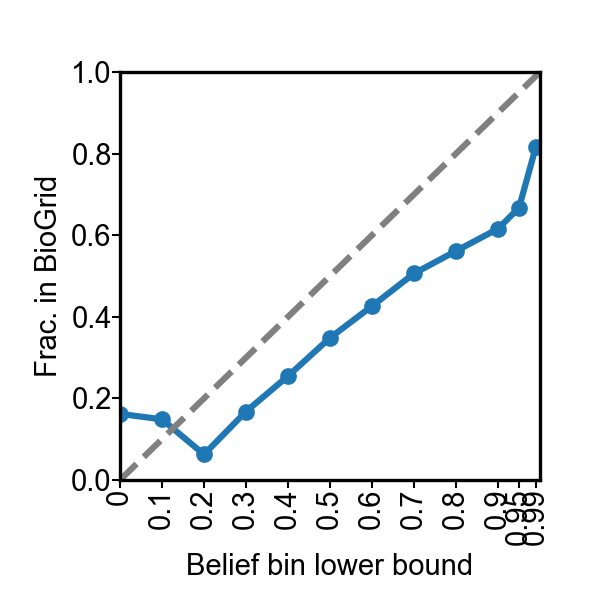

[(0, 0.16205533596837945), (0.1, 0.1486441245396719), (0.2, 0.06267420562236203), (0.3, 0.16787598944591028), (0.4, 0.2547438538060388), (0.5, 0.3484391948897192), (0.6, 0.4261924009700889), (0.7, 0.5062222222222222), (0.8, 0.5612244897959183), (0.9, 0.6158008658008658), (0.95, 0.6672979797979798), (0.99, 0.8156028368794326)]


In [17]:
fig = plot_frac_in_db(in_bg_info, bin_info, 'BioGrid')
plt.savefig(fig_path('in_bg_pct', 'pdf'))
#plt.savefig(f'output/{db_name}_stmt_percentages.pdf')

## Checking the sources for the 0.5-0.6 belief bin

Next let's look at the distribution of sources for statements in this bin. First off, how many total statements not in biogrid in this bin?

In [4]:
stmts_nobg_0506 = in_bg_info['not_in_bg_stmts']['0.5_0.6']
len(stmts_nobg_0506)

NameError: name 'in_bg_info' is not defined

What sources do these statements have?

In [15]:
source_combos = [frozenset([ev.source_api for ev in stmt.evidence]) for stmt in stmts_nobg_0506]

In [16]:
source_ctr = Counter(source_combos)
source_ctr = sorted([(k, v) for k, v in source_ctr.items()],
                     key=lambda x: x[1], reverse=True)
source_ctr[0:10]

[(frozenset({'reach', 'sparser'}), 1397),
 (frozenset({'medscan'}), 1017),
 (frozenset({'medscan', 'sparser'}), 968),
 (frozenset({'trips'}), 752),
 (frozenset({'reach'}), 422),
 (frozenset({'medscan', 'reach', 'sparser'}), 400),
 (frozenset({'medscan', 'reach'}), 311),
 (frozenset({'sparser', 'trips'}), 83),
 (frozenset({'isi', 'medscan', 'reach', 'sparser'}), 18),
 (frozenset({'reach', 'trips'}), 17)]

### Estimate total number of true positive statements

The total number of extracted statements:

In [18]:
len(indra_stmts_filt_cplx)

127300

Get the expected number of true statements:

In [19]:
expect_true = np.sum([s.belief for s in indra_stmts_filt_cplx])
expect_true

53427.61374598458

How many statements in biogrid?

In [20]:
num_in_bg = len([s for bg_stmts in in_bg_info['in_bg_stmts'].values() for s in bg_stmts])
num_in_bg

26063

How many true uncurated statements do we expect to find?

In [21]:
expect_true - num_in_bg

27364.613745984578

In [22]:
all_not_in_bg_stmts = [s for bel_bin, bel_stmts in in_bg_info['not_in_bg_stmts'].items()
                         for s in bel_stmts]

In [23]:
len(all_not_in_bg_stmts)

101237

Get the expected number of true statements:

In [24]:
np.sum([s.belief for s in all_not_in_bg_stmts])

38969.29979796601

## Return on curation effort

For each bin, figure out how many expected true but uncurated statements there are. 

In [25]:
bins_reversed = bin_info[::-1]
bin_ix_rev = list(range(len(bins_reversed)))[::-1]
num_rev = [0]
num_found = [0]
for (bin_ix, (bin_lb, bin_ub, bin_lbl)) in zip(bin_ix_rev, bins_reversed):
    num_bg = in_bg_info['in_bg_cts'][bin_ix]
    num_not_bg = in_bg_info['not_in_bg_cts'][bin_ix]
    bin_expect = np.sum([s.belief for s in in_bg_info['not_in_bg_stmts'][bin_lbl]] +
                        [s.belief for s in in_bg_info['in_bg_stmts'][bin_lbl]])
    bin_delta = bin_expect - num_bg
    delta_expect = bin_delta / num_not_bg
    if bin_delta > 0:
        num_rev.append(num_not_bg)
        num_found.append(bin_delta)
    print(bin_lbl, num_not_bg, bin_delta)
    print(f"Total in bin: {num_bg + num_not_bg}")
    print(f"Total expected correct: {bin_expect}")
    print(f"Total in biogrid: {num_bg}")
    print(f"Delta expect correct: {bin_delta}")
    print(f"Num not in biogrid: {num_not_bg}")
    print(f"Frac of not bg expect correct: {delta_expect}")
    #print(f'Expect {delta_expect} to be correct on average')
    print()
    

0.99_1.0 78.0 75.91631206752288
Total in bin: 423.0
Total expected correct: 420.9163120675229
Total in biogrid: 345.0
Delta expect correct: 75.91631206752288
Num not in biogrid: 78.0
Frac of not bg expect correct: 0.9732860521477292

0.95_0.99 527.0 480.6266697915462
Total in bin: 1584.0
Total expected correct: 1537.6266697915462
Total in biogrid: 1057.0
Delta expect correct: 480.6266697915462
Num not in biogrid: 527.0
Frac of not bg expect correct: 0.9120050660181143

0.9_0.95 710.0 572.6556284553537
Total in bin: 1848.0
Total expected correct: 1710.6556284553537
Total in biogrid: 1138.0
Delta expect correct: 572.6556284553537
Num not in biogrid: 710.0
Frac of not bg expect correct: 0.8065572231765545

0.8_0.9 1720.0 1127.8482763795555
Total in bin: 3920.0
Total expected correct: 3327.8482763795555
Total in biogrid: 2200.0
Delta expect correct: 1127.8482763795555
Num not in biogrid: 1720.0
Frac of not bg expect correct: 0.6557257420811369

0.7_0.8 2222.0 1080.973100298394
Total in bin

Let's plot the return on curation effort in terms of number of true, uncurated statements found as a function of the number statements manually reviewed.

NameError: name 'num_rev' is not defined

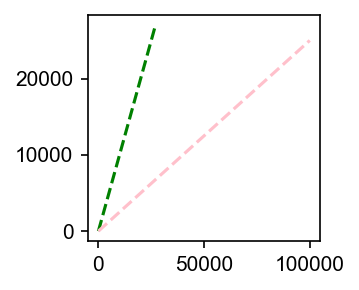

In [3]:
plt.figure(figsize=(2, 2), dpi=150)
plt.plot([0, 27000], [0, 27000], color='green', linestyle='--', label='100% return')
plt.plot([0, 100000], [0, 25000], color='pink', linestyle='--', label='25% return')
plt.plot(np.cumsum(num_rev), np.cumsum(num_found), marker='.')
plt.legend(loc='lower right', fontsize=pf.fontsize, frameon=False)
plt.xlabel('Num stmts reviewed')
plt.ylabel('Num stmts found')
ax = plt.gca()
pf.format_axis(ax)
plt.subplots_adjust(left=0.2)
plt.xscale('log')
plt.yscale('log')
plt.savefig(fig_path('return_on_curation', 'pdf'))


Let's take random samples for spot-checking:

In [104]:
cur_bin = '0.9_0.95'
random.seed(1)
stmts = in_bg_info['not_in_bg_stmts'][cur_bin]
samp = random.sample(stmts, 30)
with open('bioexp_biogrid_llr09095.pkl', 'wb') as f:
    pickle.dump(samp, f)

## Other

In [ ]:
in_bg_info['not_in_bg_stmts'].keys()

In [ ]:
len(stmts)

In [ ]:
from collections import Counter
ev_ctr = Counter([ev.source_api for s in stmts for ev in s.evidence])
ev_ctr

In [ ]:
import random
import pickle
random.seed(1)
samp = random.sample(stmts, 30)
with open('bioexp_biogrid_nobg_cplx_llr0506.pkl', 'wb') as f:
    pickle.dump(samp, f)

In [ ]:
stmts90 = in_bg_info['not_in_bg_stmts']['0.9_0.95']
stmts95 = in_bg_info['not_in_bg_stmts']['0.95_0.99']
stmts99 = in_bg_info['not_in_bg_stmts']['0.99_1.0']

In [ ]:
len(stmts90) + len(stmts95) + len(stmts99)

In [ ]:
len(stmts99)

In [ ]:
### random.seed(1)
samp99 = random.sample(stmts99, 100)
#with open('bioexp_biogrid_nobg_cplx_rf09910.pkl', 'wb') as f:
#    pickle.dump(samp99, f)

In [ ]:
foo = indra_hashes.difference(bg_hashes)
len(foo)

In [ ]:
# Filter out some problematic statements
bad_stmts1 = ac.filter_gene_list(stmts99, ['TP53', 'BIRC5'], policy='all')
bad_stmts2 = ac.filter_gene_list(stmts99, ['EIF4E', 'EIF4EBP1'], policy='all')
bad_stmts3 = ac.filter_gene_list(stmts99, ['CDKN1A'], policy='all')
bad_stmts4 = ac.filter_gene_list(stmts99, ['IL6', 'IL6ST'], policy='all')
bad_stmts = bad_stmts1 + bad_stmts2 + bad_stmts3 + bad_stmts4
stmts99_html = [s for s in stmts99 if s not in bad_stmts]

In [ ]:
len(stmts99_html)

In [ ]:
from indra.assemblers.html import HtmlAssembler
ha = HtmlAssembler(stmts99_html, db_rest_url='https://db.indra.bio')
mod = ha.make_model(no_redundancy=True)
ha.save_model('indra_stmts_not_in_biogrid_belief99.html')

In [ ]:
bad_stmts1

# Phosphosite Benchmark

In [ ]:
# Load PSP statements
psp_path = 'run_assembly/data/bioexp_phosphosite.pkl'
psp_stmts = ac.load_statements(psp_path)

In [ ]:
pa = Preassembler(bo, stmts=psp_stmts)
psp_stmts_asmb = pa.combine_duplicates()

In [ ]:
# Filter statements to Phosphorylations only
psp_stmts_filt = filter_stmts(psp_stmts_asmb, Phosphorylation)
indra_stmts_filt_phos = filter_stmts(indra_stmts, Phosphorylation)
indra_stmts_filt_phos = [s for s in indra_stmts_filt_phos if s.residue and s.position]

In [ ]:
# Set beliefs for the statements
reader_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']
#model_path = 'output/trained_loglogreg.pkl'
model_path = 'output/trained_nopsp_loglogreg.pkl'
skls = SklearnScorer(model_path, reader_list)
skls.score_statements(indra_stmts_filt_phos)

In [ ]:
# Get hashes of both sets of statements for comparison:
psp_hashes = set([s.get_hash(refresh=True) for s in psp_stmts_filt])

In [ ]:
# Build a dictionary of text-mined statements by hash so we can get them back
# from the hashes:
stmts_by_hash_phos = {s.get_hash(refresh=True): s for s in indra_stmts_filt_phos}

In [ ]:
bin_bounds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]
bin_info = get_bin_info(bin_bounds)

In [ ]:
in_psp_info = stmts_in_bg_by_belief(indra_stmts_filt_phos, psp_hashes, bin_info,
                                    stmts_by_hash_phos)

In [ ]:
plot_in_db(in_psp_info, bin_info, 'PSP')

In [ ]:
plot_frac_in_db(in_psp_info, bin_info, 'PSP')

In [ ]:
stmts60 = in_psp_info['not_in_bg_stmts']['0.6_0.7']
stmts99 = in_psp_info['not_in_bg_stmts']['0.99_1.0']

In [ ]:
random.seed(1)
samp99 = random.sample(stmts99, 100)
ha = HtmlAssembler(samp99, db_rest_url='https://db.indra.bio')
mod = ha.make_model(no_redundancy=True)
ha.save_model('indra_stmts_not_in_psp_belief99.html')

In [ ]:
samp60 = random.sample(stmts60, 100)
ha = HtmlAssembler(samp60, db_rest_url='https://db.indra.bio')
mod = ha.make_model(no_redundancy=True)
ha.save_model('indra_stmts_not_in_psp_belief60.html')

In [ ]:
with open('bioexp_psp_nopsp_phos_lr0608.pkl', 'wb') as f:
    pickle.dump(samp60, f)